In [1]:
# Imports
import zstandard as zstd
import json
import os
import io
from tqdm import tqdm

from einops import rearrange
import torch as t
from nnsight import LanguageModel
from dictionary_learning.buffer import ActivationBuffer
from dictionary_learning.dictionary import AutoEncoder
from dictionary_learning.training import trainSAE

import matplotlib.pyplot as plt
import imageio
from circuitsvis.activations import text_neuron_activations

/home/can/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Experiment setup
### Global variables 

In [2]:
# Testing Parameters
layer = 3
activation_dim=512
dictionary_size = 64 * activation_dim # This is the dict_size sam mostly works with.

eps = 1e-8

### Load Model, SAE and Data

In [3]:
model = LanguageModel('EleutherAI/pythia-70m-deduped', device_map='cuda:0')
submodule = model.gpt_neox.layers[layer].mlp.dense_4h_to_h

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
# set up data as a generator
data_path = '/share/data/datasets/pile/the-eye.eu/public/AI/pile/train/00.jsonl.zst'
compressed_file = open(data_path, 'rb')
dctx = zstd.ZstdDecompressor()
reader = dctx.stream_reader(compressed_file)
text_stream = io.TextIOWrapper(reader, encoding='utf-8')
def generator():
    for line in text_stream:
        yield json.loads(line)['text']
data = generator()

In [5]:
buffer = ActivationBuffer(
    data,
    model,
    submodule,
    io='out',
    in_feats=activation_dim,
    out_feats=activation_dim,
    in_batch_size=512,
    out_batch_size=2 ** 15,
    n_ctxs=1e4,
)

In [6]:
# returns activations on dataset examples for the submodule specified
# for each example, activations per each token positon are concatenated along dim out_batch_size

acts = next(buffer) # [out_batch_size, activation_size]
acts.shape

refreshing buffer...


You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


buffer refreshed...


torch.Size([32768, 512])

In [7]:
ae = AutoEncoder(activation_dim, dictionary_size).cuda()
ae.load_state_dict(
    t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{layer}/1_{dictionary_size}/ae.pt')
)

<All keys matched successfully>

# Mean feature activation – random contexts
for final token prediction, one activation per prompt.

In [8]:
# Probs look at other interpretability measures from anthropic paper, too?

Text(0, 0.5, 'Frequency')

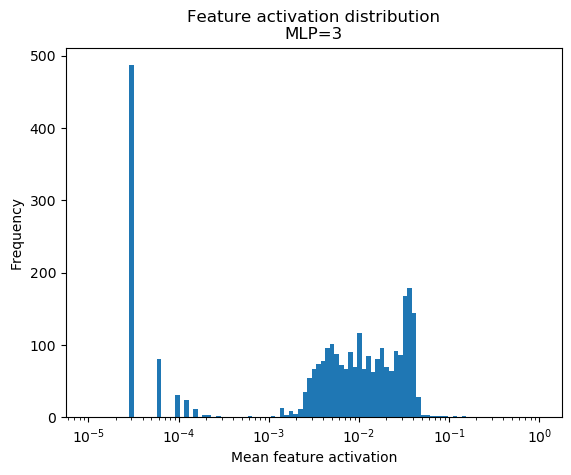

In [9]:
dict_acts_random = ae.encode(acts.cuda()) # [batch, dictionary_size]
mean_acts_random = (dict_acts_random !=0 ).sum(dim=0) / dict_acts_random.shape[0]

plt.figure()
plt.hist(mean_acts_random.cpu(), bins=t.logspace(-5, 0, 100))
plt.xscale('log')
plt.title(f'Feature activation distribution\nMLP={layer}');
plt.xlabel('Mean feature activation')
plt.ylabel('Frequency')

In [10]:
# mean feature activation for multiple checkpoints
# make gif
def make_gif_mean_feat_activation():
    for checkpoint in range(0, 101000, 5000):
        ae = AutoEncoder(activation_dim, dictionary_size).cuda()
        ae.load_state_dict(
            t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{layer}/1_{dictionary_size}/checkpoints/ae_{checkpoint}.pt')
        )

        dict_acts = ae.encode(acts.cuda())
        freqs = (dict_acts !=0).sum(dim=0) / dict_acts.shape[0]

        plt.figure()
        plt.hist(freqs.cpu(), bins=t.logspace(-5, 0, 100))
        plt.xscale('log')
        plt.title(f'Layer {layer} - checkpoint {checkpoint}, 1_32768')
        plt.savefig(f'junk/{checkpoint}_hist.png')
        plt.close()
    
    images = [
        imageio.imread(f'junk/{checkpoint}_hist.png')
        for checkpoint in range(0, 103000, 5000)
    ]
    imageio.mimsave('junk/hist.gif', images, fps=1)

# Mean feature activation – fewer contexts

mean over batch and token_position

In [11]:
# Get mean feature activations from autoencoder same as 
inputs = buffer.tokenized_batch(batch_size=512) # [batch, n_ctx]
with model.generate(max_new_tokens=1, pad_token_id=model.tokenizer.pad_token_id) as generator:
    with generator.invoke(inputs['input_ids'], scan=False) as invoker:
        hidden_states = submodule.output.save() # hidden_states.value: [batch, n_ctx, d_mlp]
dictionary_activations = ae.encode(hidden_states.value) 
flattened_acts = rearrange(dictionary_activations, 'b n d -> (b n) d')
mean_activations = (flattened_acts !=0).sum(dim=0) / flattened_acts.shape[0] # [d_sae]

### Analyze frequencies in second mode
Second mode refers to the smaller frequency peak usually above 1e-2 in mean feature activations.

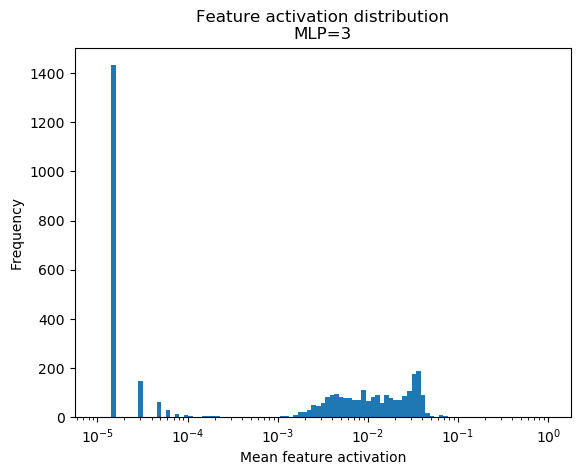

In [12]:
plt.figure()
plt.hist(mean_activations.cpu(), bins=t.logspace(-5, 0, 100))
plt.xscale('log')
plt.title(f'Feature activation distribution\nMLP={layer}');
plt.xlabel('Mean feature activation')
plt.ylabel('Frequency');

In [13]:
for idx, freq in enumerate(mean_activations):
    if 1e-1 < freq:
        print(f"feat {idx} freq: {freq}")

feat 1420 freq: 0.111968994140625
feat 19432 freq: 0.1187286376953125
feat 22260 freq: 0.1329193115234375


Manually setting interval for second peak could be improved with interactive click and drag interval. plotly?

# Visualize top k prompts with highest feature activation

In [14]:
def list_decode(x):
    if isinstance(x, int):
        return model.tokenizer.decode(x)
    else:
        return [list_decode(y) for y in x]
    
def topk_prompts_provider(feature_id: int, k: int = 30):
    # Sort examples in batch by max feature activation
    acts = dictionary_activations[:, :, feature_id].cpu() # acts: [batch, pos]
    flattened_acts = rearrange(acts, 'b l -> (b l)')
    topk_indices = t.argsort(flattened_acts, dim=0, descending=True)[:k] 
    batch_indices = topk_indices // acts.shape[1]
    token_indices = topk_indices % acts.shape[1]

    # Visualize
    tokens = [
    inputs['input_ids'][batch_idx, :token_idx+1].tolist() for batch_idx, token_idx in zip(batch_indices, token_indices)
    ]
    tokens = list_decode(tokens)
    activations = [
        acts[batch_idx, :token_id+1, None, None] for batch_idx, token_id in zip(batch_indices, token_indices)
    ]
    return tokens, activations

In [15]:
tokens, activations = topk_prompts_provider(feature_id=1202)
text_neuron_activations(tokens, activations)

# Plural feature (testing acdc.py)
What's the plural feature?

### Setup

In [16]:
# Create toy dataset
clean = (
    "The man", " is"
)
patch = (
    "The men", " are"
)
plural_token_pos = 1

tok = lambda x: t.tensor(model.tokenizer.encode(x))
toy_dataset = [dict(
    clean_prefix=tok(clean[0]),
    clean_answer=tok(clean[1]),
    patch_prefix=tok(patch[0]),
    patch_answer=tok(patch[1]),

)]

toy_dataset[0]['clean_prefix']

tensor([510, 637])

### Patching_on_y

In [19]:
from acdc import patching_on_y

effects, total_effect = patching_on_y(
    toy_dataset,
    model,
    [submodule],
    [ae],
    method='separate'
)
plural_effect = effects[submodule][plural_token_pos].detach().cpu()

print(f'total metric diff after replacing clean prefix with patch prefix: {total_effect}')

total metric diff after replacing clean prefix with patch prefix: 8.80322265625


In [20]:
# TopK features with highest mean activation
topk_effects = sorted(enumerate(plural_effect), key=lambda x: x[1].abs(), reverse=True)

topk_features = []
for i, eff in topk_effects[:10]:
    topk_features.append(i)
    print(f'feat {i}:\t {eff}')

feat 26928:	 0.11726246774196625
feat 23612:	 0.03022793121635914
feat 31715:	 0.03022793121635914
feat 20945:	 0.029871640726923943
feat 21363:	 -0.029479725286364555
feat 6540:	 -0.022604554891586304
feat 1182:	 0.0225429255515337
feat 25349:	 0.0225429255515337
feat 21615:	 0.019924858585000038
feat 30457:	 -0.016939667984843254


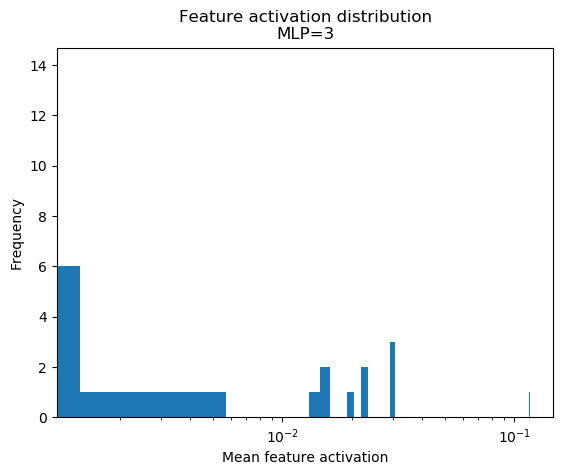

In [21]:
plt.figure()
plt.hist(plural_effect[plural_effect.abs() > eps], bins=100)
plt.xscale('log')
plt.title(f'Feature activation distribution\nMLP={layer}');
plt.xlabel('Mean feature activation')
plt.ylabel('Frequency');

In [22]:
tokens, activations = topk_prompts_provider(feature_id=topk_features[0])
text_neuron_activations(tokens, activations)

In [23]:
tokens, activations = topk_prompts_provider(feature_id=topk_features[1])
text_neuron_activations(tokens, activations)

In [24]:
tokens, activations = topk_prompts_provider(feature_id=topk_features[2])
text_neuron_activations(tokens, activations)